  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import pyarrow

  ### Definition of names for plots and files

In [2]:

date = '20200916'

#names of files with features and labels for the training set (v7)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features_20200916/'

features_file = features_path+'features_for_ML_with_WISE_20200916.parquet'

#features_file = '../ZTF_data/features_20200109_phot_corrected_withWISE_withSNfeat_withMHPScorrected.csv'

class_output = '../ZTF_classifications/classes_BHRF_TSv7_original_hierarchical_classes_'+date

#where the RF models are saved

model_first_layer = 'final_BHRF_model_20200916/models/hierarchical_level_RF_model.pkl'
model_periodic_layer = 'final_BHRF_model_20200916/models/periodic_level_RF_model.pkl'
model_transient_layer = 'final_BHRF_model_20200916/models/stockastic_level_RF_model.pkl'
model_stochastic_layer = 'final_BHRF_model_20200916/models/transient_level_RF_model.pkl'

features_pickle = 'final_BHRF_model_20200916/models/features_RF_model.pkl'    
    
#confusion matrixes

conf_matrix_name_first_layer = 'final_BHRF_model_20200916/plots/confusion_matrix_rf_model_2_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'final_BHRF_model_20200916/plots/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances

feature_importance_name_first_layer = 'final_BHRF_model_20200916/plots/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
feature_importance_name_periodic_layer = 'final_BHRF_model_20200916/plots/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
feature_importance_name_transient_layer = 'final_BHRF_model_20200916/plots/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
feature_importance_name_stochastic_layer = 'final_BHRF_model_20200916/plots/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF17aaaablp     0.373062     0.347510           1.000000           1.000000   
ZTF17aaaafbp     0.145461     0.067991           0.987704           0.352564   
ZTF17aaaagwr     0.227029     0.214442           0.999419           1.000000   
ZTF17aaaappe     0.171415     0.198225           1.000000           1.000000   
ZTF17aaabbkl     0.298872     0.181823           0.910127           0.730757   

              Autocor_length_1  Autocor_length_2  Beyond1Std_1  Beyond1Std_2  \
oid                                                                            
ZTF17aaaablp               1.0               1.0      0.362069      0.243902   
ZTF17aaaafbp               1.0               1.0      0.307692      0.333333   
ZTF17aaaagwr               1.0               1.0      0.391304      0.130435   
ZTF17aaaappe               1.0  

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[(df_labels['source']!="ASASSN") & (df_labels['source']!="GAIADR2VS")]
#df_labels = df_labels[(df_labels['source']!="ASASSN") ]

df_labels = df_labels[(df_labels['class_source']!="ELL")]


bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)


#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(173041,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
#'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
#print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
#print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

118250


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abmposz,0.049148,-999.000000,0.731614,-999.000000,1.0,-999.0,0.285714,-999.0000,0.0,-999.0,...,0.000000,0.000000,0.964286,0.229601,0.903,3.180,-999.000000,-999.000000,9.393882,6.213882
ZTF19aapcxhy,-999.000000,0.049909,-999.000000,0.204718,-999.0,1.0,-999.000000,0.3750,-999.0,0.0,...,1.000000,1.000000,0.814286,0.013542,0.796,2.889,8.094448,5.205448,-999.000000,-999.000000
ZTF18abtyspw,0.167052,-999.000000,1.000000,-999.000000,1.0,-999.0,0.111111,-999.0000,0.0,-999.0,...,0.888889,0.333333,0.900000,0.426247,1.046,2.962,-999.000000,-999.000000,9.100768,6.138768
ZTF18aaodoxr,0.067875,0.082576,0.988717,0.999999,6.0,11.0,0.337662,0.4375,0.0,0.0,...,0.000000,0.000000,0.931429,0.091583,0.664,3.081,8.062663,4.981663,8.814672,5.733672
ZTF18acidtzj,0.044463,-999.000000,0.966210,-999.000000,1.0,-999.0,0.333333,-999.0000,0.0,-999.0,...,0.000000,0.000000,0.937143,0.056458,0.755,2.591,-999.000000,-999.000000,8.203748,5.612748


In [6]:
#print(df.columns)
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MHPS_high_1' 'MHPS_high_2' 'MHPS_low_1' 'MHPS_low_2'
 'MHPS_rati

In [7]:
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1289
SNIbc 92
SNII 325
SLSN 22
QSO 20622
AGN 4248
Blazar 1234
YSO 1766
CV/Nova 884
LPV 14374
E 38136
DSCT 731
RRL 32607
CEP 613
Periodic-Other 1307


Counter({'E': 38136, 'RRL': 32607, 'QSO': 20622, 'LPV': 14374, 'AGN': 4248, 'YSO': 1766, 'Periodic-Other': 1307, 'SNIa': 1289, 'Blazar': 1234, 'CV/Nova': 884, 'DSCT': 731, 'CEP': 613, 'SNII': 325, 'SNIbc': 92, 'SLSN': 22})
                number
E                38136
RRL              32607
QSO              20622
LPV              14374
AGN               4248
YSO               1766
Periodic-Other    1307
SNIa              1289
Blazar            1234
CV/Nova            884
DSCT               731
CEP                613
SNII               325
SNIbc               92
SLSN                22


Text(0, 0.5, '$\\#$ of sources')

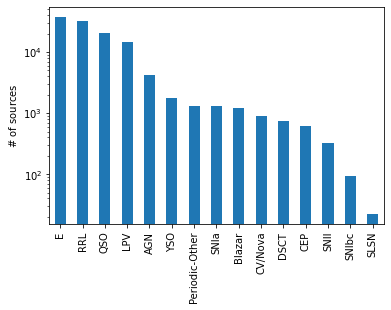

In [8]:
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of sources')

#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/number_sources_labeled_set.pdf',bbox_inches='tight')

  ### Defining functions to plot the confusion matrix and the feature importance

In [9]:
'''def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()'''
    
    
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data

In [10]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

118250
118250
70214 23003 1383


In [11]:
print(X_train_hierarchical.index)
print(X_test_hierarchical.index)

np.save('final_BHRF_model_20200916/labels_training_sample', X_train_hierarchical.index.values)
np.save('final_BHRF_model_20200916/labels_testint_sample', X_test_hierarchical.index.values)

Index(['ZTF18abebjld', 'ZTF18acstcwr', 'ZTF18aaaauax', 'ZTF17aaadovu',
       'ZTF17aaagzfp', 'ZTF17aacfnuw', 'ZTF18abdtanl', 'ZTF18abdeykv',
       'ZTF18abctask', 'ZTF18abdpufh',
       ...
       'ZTF18abjqikm', 'ZTF19aaephni', 'ZTF17aacnjgb', 'ZTF18abmxaop',
       'ZTF18abdqyme', 'ZTF18aaykmnr', 'ZTF18abshvzh', 'ZTF18acufeuz',
       'ZTF17aaajjpk', 'ZTF18abcrohd'],
      dtype='object', name='oid', length=94600)
Index(['ZTF18absghpg', 'ZTF18aabsfxz', 'ZTF18abcnzea', 'ZTF18aabkmzd',
       'ZTF17aacnsyp', 'ZTF18abilbue', 'ZTF19abagcht', 'ZTF18aceiorp',
       'ZTF18aaaepqo', 'ZTF18abbwvuf',
       ...
       'ZTF18abeqwqi', 'ZTF17aadfzdm', 'ZTF18aaadyuc', 'ZTF18aayxngb',
       'ZTF18abtmwok', 'ZTF18abvfjwv', 'ZTF19aagmurz', 'ZTF18abzqgwz',
       'ZTF19aalzctn', 'ZTF19ablerhr'],
      dtype='object', name='oid', length=23650)


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [12]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)
        
with open(model_first_layer, 'wb') as f:
            pickle.dump(
                rf_model_hierarchical,
                f,
                pickle.HIGHEST_PROTOCOL)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9874418604651163
Balanced accuracy: 0.9845935448515433


[[  343     1     1]
 [   23  5549   179]
 [   13    80 17461]]
Normalized confusion matrix
[[99.  0.  0.]
 [ 0. 96.  3.]
 [ 0.  0. 99.]]


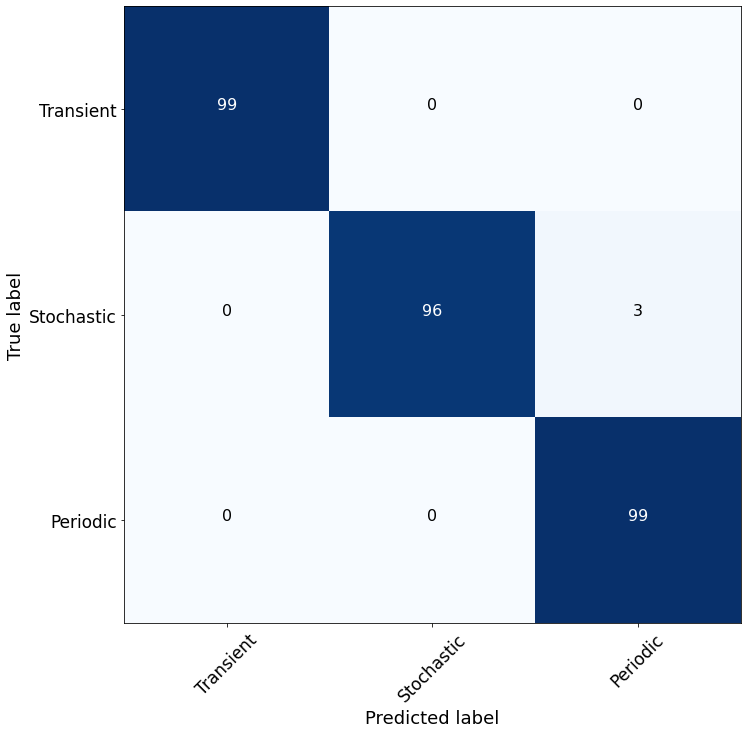

In [13]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,'final_BHRF_model_20200916/plots/training_conf_matrix_hierarchical_level.pdf')

W1-W2 & 0.100
positive_fraction_2 & 0.048
LinearTrend_2 & 0.048
sgscore1 & 0.047
positive_fraction_1 & 0.040
W2-W3 & 0.034
SPM_chi_1 & 0.033
SPM_tau_rise_1 & 0.031
g-W3 & 0.031
SPM_chi_2 & 0.025
SPM_gamma_1 & 0.025
n_non_det_after_fid_2 & 0.023
g-W2 & 0.023
SPM_tau_rise_2 & 0.023
SPM_tau_fall_1 & 0.020
SPM_A_2 & 0.018
r-W3 & 0.017
r-W2 & 0.015
Rcs_2 & 0.015
SPM_A_1 & 0.015
ExcessVar_2 & 0.013
SF_ML_amplitude_2 & 0.013
LinearTrend_1 & 0.013
SPM_gamma_2 & 0.011
ExcessVar_1 & 0.011
GP_DRW_sigma_2 & 0.010
SPM_t0_1 & 0.010
Meanvariance_2 & 0.009
delta_mag_fid_2 & 0.009
MHPS_low_2 & 0.009


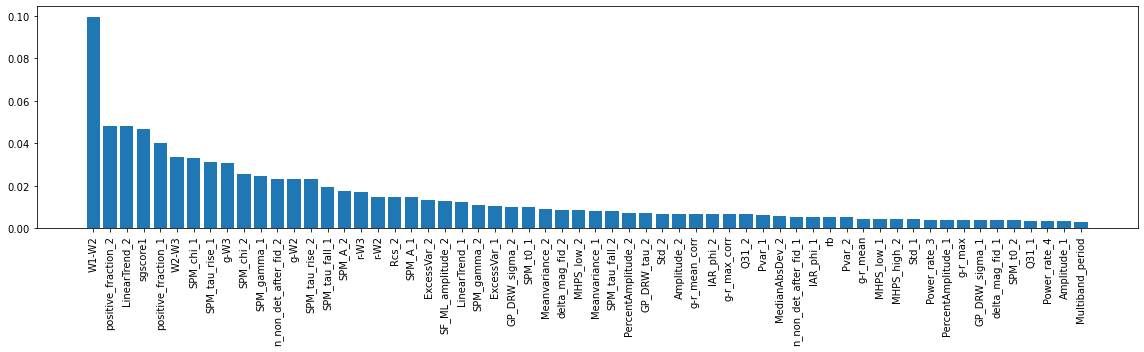

In [14]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, 'final_BHRF_model_20200916/plots/feature_ranking_hierarchical_level.pdf')

  ### Periodic layer

In [15]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as f:
            pickle.dump(
                rf_model_periodic,
                f,
                pickle.HIGHEST_PROTOCOL)

['CEP' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


93
Multiband_period & 0.092
g-W2 & 0.057
r-W2 & 0.033
g-W3 & 0.032
g-r_max_corr & 0.030
g-r_mean & 0.028
g-r_mean_corr & 0.027
g-r_max & 0.024
GP_DRW_tau_1 & 0.022
Amplitude_1 & 0.018
r-W3 & 0.018
IAR_phi_1 & 0.017
GP_DRW_sigma_1 & 0.016
ExcessVar_1 & 0.016
delta_mag_fid_1 & 0.016
Std_1 & 0.015
Meanvariance_1 & 0.014
GP_DRW_tau_2 & 0.011
PercentAmplitude_1 & 0.011
Autocor_length_1 & 0.010
W1-W2 & 0.009
MHPS_high_1 & 0.009
W2-W3 & 0.009
SPM_A_1 & 0.008
SF_ML_gamma_1 & 0.008
Gskew_1 & 0.008
SF_ML_amplitude_1 & 0.008
MedianAbsDev_1 & 0.007
delta_mag_fid_2 & 0.007
SPM_A_2 & 0.007


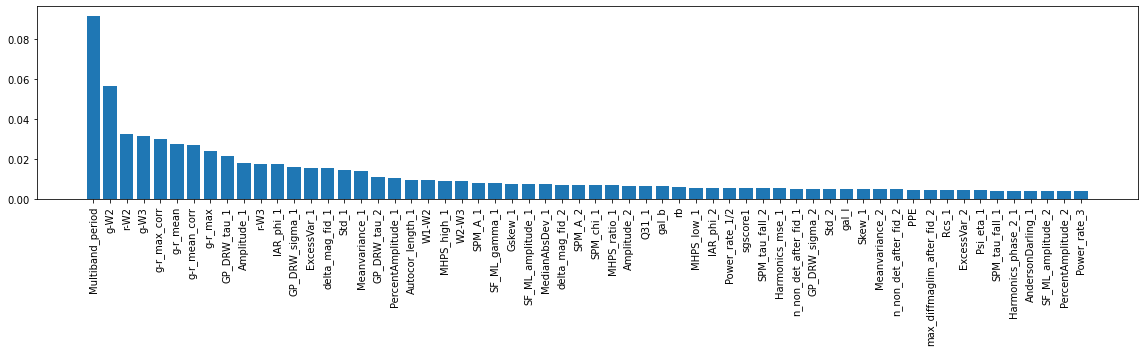

In [16]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, 'final_BHRF_model_20200916/plots/feature_ranking_periodic_level.pdf')

  ### Stochastic layer

In [17]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)


with open(model_stochastic_layer, 'wb') as f:
            pickle.dump(
                rf_model_stochastic,
                f,
                pickle.HIGHEST_PROTOCOL)

['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO']


W1-W2 & 0.119
sgscore1 & 0.063
r-W2 & 0.053
gal_b & 0.043
g-r_mean_corr & 0.039
ExcessVar_2 & 0.036
g-W2 & 0.033
r-W3 & 0.030
W2-W3 & 0.030
g-r_max_corr & 0.029
delta_mag_fid_2 & 0.028
Meanvariance_2 & 0.026
g-W3 & 0.025
g-r_mean & 0.020
SPM_A_2 & 0.018
Amplitude_2 & 0.017
PercentAmplitude_2 & 0.015
Std_2 & 0.014
g-r_max & 0.012
rb & 0.012
SPM_A_1 & 0.011
delta_mag_fid_1 & 0.011
IAR_phi_1 & 0.009
GP_DRW_sigma_2 & 0.009
MHPS_high_2 & 0.008
IAR_phi_2 & 0.008
MHPS_low_2 & 0.007
GP_DRW_tau_2 & 0.007
Pvar_2 & 0.007
ExcessVar_1 & 0.007


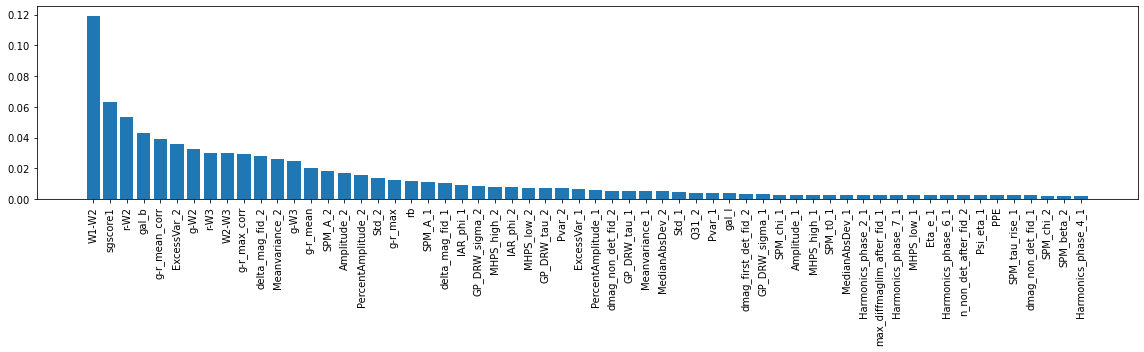

In [18]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, 'final_BHRF_model_20200916/plots/feature_ranking_stochastic_level.pdf')


  ### Transient layer

In [19]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)
        
with open(features_pickle, 'wb') as f:
            pickle.dump(
                features_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


SPM_t0_1 & 0.035
SPM_gamma_2 & 0.030
SPM_t0_2 & 0.029
SPM_tau_rise_1 & 0.025
SPM_tau_rise_2 & 0.022
MHPS_ratio_1 & 0.022
g-r_max & 0.021
SPM_gamma_1 & 0.016
SPM_tau_fall_1 & 0.014
MHPS_high_1 & 0.013
dmag_first_det_fid_1 & 0.013
dmag_first_det_fid_2 & 0.012
LinearTrend_2 & 0.012
AndersonDarling_2 & 0.012
g-r_mean & 0.011
PPE & 0.011
MHPS_high_2 & 0.010
IAR_phi_2 & 0.010
IAR_phi_1 & 0.010
sgscore1 & 0.010
Skew_2 & 0.009
SPM_beta_2 & 0.009
MHPS_ratio_2 & 0.009
Harmonics_phase_2_2 & 0.009
Psi_CS_2 & 0.009
SPM_A_2 & 0.008
dmag_non_det_fid_1 & 0.008
Power_rate_3 & 0.008
MHPS_low_2 & 0.008
MHPS_low_1 & 0.008


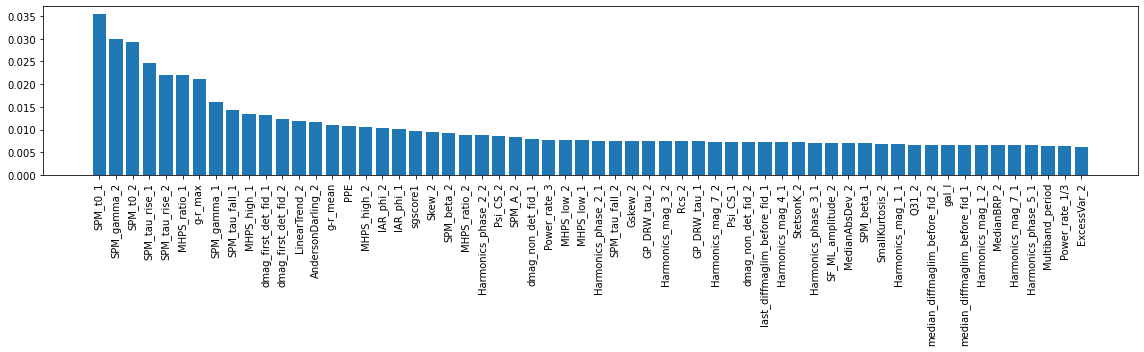

In [20]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, 'final_BHRF_model_20200916/plots/feature_ranking_transient_level.pdf')



 ## Putting al layers together  


In [21]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 7.971027783753448e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


[[ 181   61   14    1    0    0    0    0    0    0    0    0    0    0
     1]
 [   6   10    2    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   7   15   30   12    0    1    0    0    0    0    0    0    0    0
     0]
 [   0    0    1    3    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0 3576  368  158    4   14    1    0    0    1    0
     2]
 [   0    1    1    0   90  718   36    2    0    0    0    0    0    0
     2]
 [   0    0    0    0   44   18  179    3    3    0    0    0    0    0
     0]
 [   0    0    1    0    0    0    2  291    2    8    5    2    2   12
    28]
 [  10    4    0    0    0    0    0    1  125    3    1    6   19    4
     4]
 [   1    1    0    0    0    1    0   47    1 2782    0    0    1   21
    20]
 [   0    0    0    0   14    1    3   33   48    2 5667  518  201  259
   881]
 [   0    0    0    0    0    0    0    0    0    0   13  123    2    1
     7]
 [   0    2    1    0   20    1    1   1

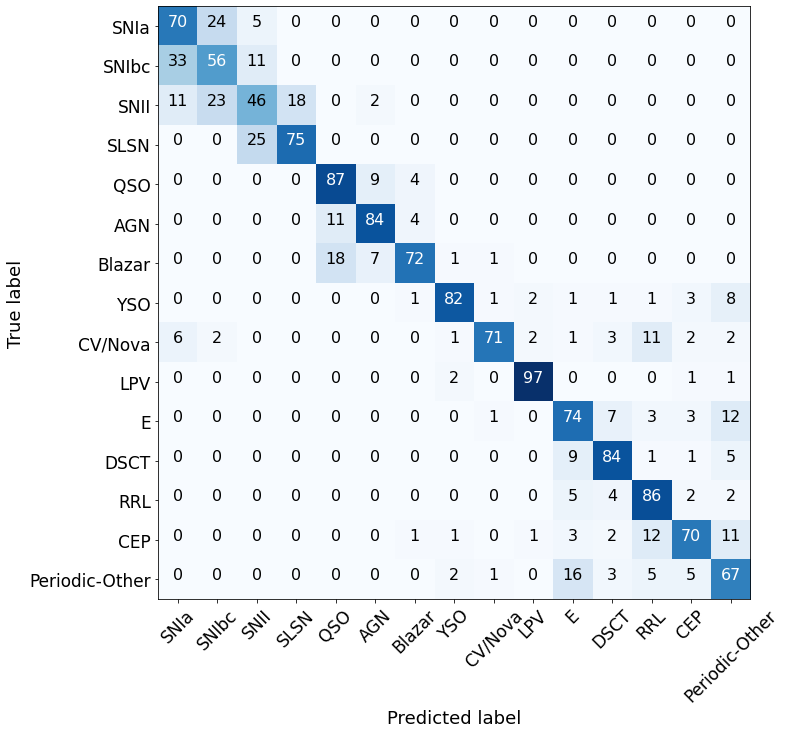

In [22]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, 'final_BHRF_model_20200916/plots/conf_matrix_multiclass_level.pdf')

print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("macro precision: ","%0.2f" %  metrics.precision_score(y_test_original, class_final_name, average='macro'))
print("macro recall: ","%0.2f" %  metrics.recall_score(y_test_original, class_final_name, average='macro'))
print("macro F1: ","%0.2f" %  metrics.f1_score(y_test_original, class_final_name, average='macro'))

print(metrics.classification_report(y_test_original, class_final_name, digits=2))

In [23]:
# Kaggle score

num_y_test =  class_final_index
class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = label_order

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

[6.111111111111111, 87.5925925925926, 24.256410256410255, 394.1666666666667, 0.38231490462334305, 1.8549019607843138, 6.383265856950067, 4.466477809254013, 8.907721280602637, 0.5484057971014493, 0.20672173418993925, 10.799086757990867, 0.24174588572012676, 12.818428184281842, 6.040868454661558]
SNIa -0.032150537402859655
SNIbc -0.04921554112182073
SNII -0.06665356419427704
SLSN -0.024804738104133067
QSO -0.05358619926858353
AGN -0.06464440390880871
Blazar -0.07553390612026122
YSO -0.06437311099510527
CV/Nova -0.07668450798027279
LPV -0.05898744023834861
E -0.06252656131991811
DSCT -0.04546035800997718
RRL -0.02024958587559905
CEP -0.06274151495670474
Periodic-Other -0.03355391634703347
0.7911658858437032


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other'], y=oid
ZTF18absghpg     RRL
ZTF18aabsfxz       E
ZTF18abcnzea     LPV
ZTF18aabkmzd       E
ZTF17aacnsyp       E
ZTF18abilbue     RRL
ZTF19abagcht     RRL
ZTF18aceiorp     AGN
ZTF18aaaepqo       E
ZTF18abbwvuf     RRL
ZTF18absigjp     RRL
ZTF18abcwala     LPV
ZTF17aabsvdb     RRL
ZTF18abmagup       E
ZTF18abclntz     RRL
ZTF17aabwhqi       E
ZTF18acwycty     RRL
ZTF18aczexiw       E
ZTF18aavpekw     RRL
ZTF18abfnxfh     QSO
ZTF18aczerke     QSO
ZTF18abjreaq       E
ZTF19aagpant     QSO
ZTF18acviasy       E
ZTF18adbaioi     RRL
ZTF18aaxaoyc     LPV
ZTF18acegbsn       E
ZTF18acnnxor    SNIa
ZTF18aacjqpu     QSO
ZTF17aacpwzi       E
                ... 
ZTF18adccpxb     QSO
ZTF18abvbtep     LPV
ZTF18acetmzq     RRL
ZTF18aaaaatj       E
ZTF18aaadrnw       E
ZTF18a

  ## Classifying unlabeled data

In [24]:
#loading the data
print(rm_nd_cols)

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

df_feat_ul_out = df_feat_ul

df_feat_ul.head()

['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'MHAOV_Period_1', 'MHAOV_Period_2']


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaablp,0.373062,0.347510,1.000000,1.000000,1.0,1.0,0.362069,0.243902,0.0,0.0,...,0.310345,0.707317,0.822857,1.000000,-0.307,2.322,4.090566,1.768566,4.960173,2.638173
ZTF17aaaafbp,0.145461,0.067991,0.987704,0.352564,1.0,1.0,0.307692,0.333333,0.0,0.0,...,0.076923,0.000000,0.770714,0.996167,-0.114,0.950,3.282234,2.332234,3.872326,2.922326
ZTF17aaaagwr,0.227029,0.214442,0.999419,1.000000,1.0,1.0,0.391304,0.130435,0.0,0.0,...,0.260870,0.869565,0.754286,0.993750,-0.059,1.597,3.493749,1.896749,4.399738,2.802738
ZTF17aaaappe,0.171415,0.198225,1.000000,1.000000,1.0,1.0,0.193548,0.456522,0.0,0.0,...,0.806452,0.521739,0.800000,1.000000,-0.156,3.224,4.811004,1.587004,5.003890,1.779890
ZTF17aaabbkl,0.298872,0.181823,0.910127,0.730757,1.0,1.0,0.411765,0.294118,0.0,0.0,...,0.176471,0.000000,0.797143,0.989000,-0.075,1.152,3.812027,2.660027,4.684277,3.532277


In [27]:
#predicting classes of unlabeled data

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
classes_order_proba_periodic = rf_model_periodic.classes_
classes_order_proba_stochastic = rf_model_stochastic.classes_
classes_order_proba_transient = rf_model_transient.classes_



test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)

In [28]:
#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names_ul)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


prob_org_ul =  np.concatenate((test_Y_proba_stochastic,test_Y_proba_transient,test_Y_proba_periodic),axis=1)




[1. 1. 1. ... 1. 1. 1.] 1.0 8.699861986583052e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


In [40]:
#Writing results in the output
df_out = df_feat
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out


probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

probs_org_header = prob_final_class_names_ul + '_prob_org' #original probabilities

prob_pd_ul_org = pd.DataFrame(prob_org_ul,columns=probs_org_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul_org).join(prob_pd_ul).join(prob_h_pd_ul)


test_data_just_class = df_out[['W1-W2','W2-W3','g-W2','g-W3','r-W2','r-W3','predicted_class','predicted_class_proba']].join(prob_pd_ul_org).join(prob_pd_ul).join(prob_h_pd_ul)

#test_data_withclass.to_csv(class_output)

test_data_just_class.head()


(898315, 184)
898315
898315


,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3,predicted_class,predicted_class_proba,AGN_prob_org,Blazar_prob_org,...,SNIbc_prob,CEP_prob,DSCT_prob,E_prob,LPV_prob,Periodic-Other_prob,RRL_prob,prob_Periodic,prob_Stochastic,prob_Transient
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaablp,-0.307,2.322,2.638173,4.960173,1.768566,4.090566,E,0.548900,0.006,0.040,...,0.000524,0.097804,0.045908,0.548900,0.000000,0.083832,0.221556,0.998,0.000,0.002
ZTF17aaaafbp,-0.114,0.950,2.922326,3.872326,2.332234,3.282234,Periodic-Other,0.404712,0.028,0.058,...,0.001680,0.042504,0.088704,0.351120,0.003696,0.404712,0.033264,0.924,0.068,0.008
ZTF17aaaagwr,-0.059,1.597,2.802738,4.399738,1.896749,3.493749,E,0.630912,0.004,0.038,...,0.000000,0.049600,0.099200,0.630912,0.009920,0.180544,0.021824,0.992,0.008,0.000
ZTF17aaaappe,-0.156,3.224,1.779890,5.003890,1.587004,4.811004,E,0.580060,0.008,0.060,...,0.001780,0.013580,0.102820,0.580060,0.001940,0.145500,0.126100,0.970,0.020,0.010
ZTF17aaabbkl,-0.075,1.152,3.532277,4.684277,2.660027,3.812027,Periodic-Other,0.379544,0.012,0.040,...,0.001520,0.105328,0.041768,0.328696,0.005448,0.379544,0.047216,0.908,0.084,0.008


In [30]:
#test_data_withclass.to_csv(class_output+'.csv')

In [42]:
test_data_just_class.to_parquet(class_output+'.parquet')
test_data_just_class.to_csv(class_output+'.csv')

Counter({'Periodic-Other': 246934, 'E': 214095, 'LPV': 163321, 'YSO': 101073, 'RRL': 56755, 'QSO': 35631, 'DSCT': 27140, 'CEP': 20010, 'AGN': 12849, 'CV/Nova': 8429, 'Blazar': 4568, 'SNIa': 4096, 'SNIbc': 1809, 'SNII': 1060, 'SLSN': 545})
                number
Periodic-Other  246934
E               214095
LPV             163321
YSO             101073
RRL              56755
QSO              35631
DSCT             27140
CEP              20010
AGN              12849
CV/Nova           8429
Blazar            4568
SNIa              4096
SNIbc             1809
SNII              1060
SLSN               545


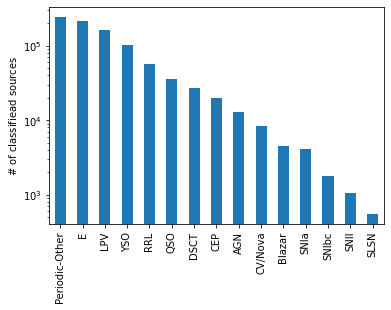

In [32]:
class_counts = Counter(class_final_name_ul)
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of classifiead sources')

plt.savefig('final_BHRF_model_20200916/plots/number_classified_sources.pdf',bbox_inches='tight')

0 SNIa 0.97
1 SNIbc 0.882
2 SNII 0.921
3 SLSN 0.792
4 QSO 0.988
5 AGN 0.95
6 Blazar 0.846
7 YSO 0.42
8 CV/Nova 0.408
9 LPV 0.776
10 E 0.934
11 DSCT 0.904
12 RRL 0.966
13 CEP 0.874
14 Periodic-Other 0.782


Text(0.5, 0, 'Predicted hierarchical level probability ($\\mathcal{P}_{H_{BHRF}}$)')

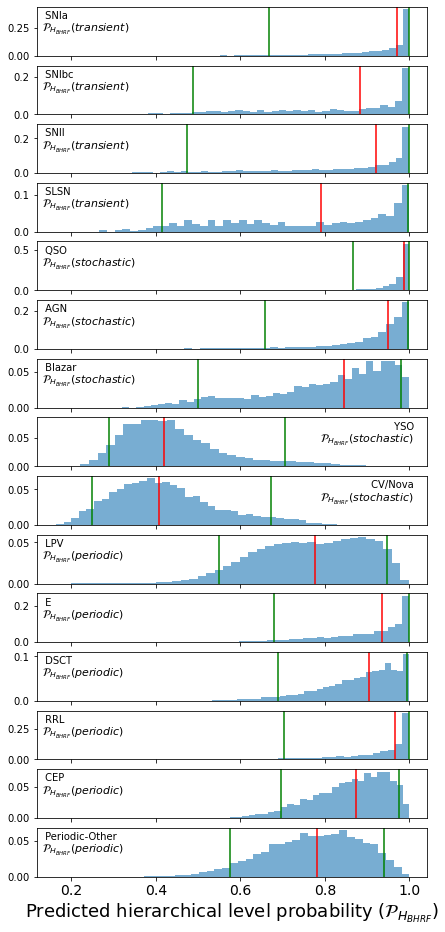

In [33]:
#plotting hierarchical level probabilities
fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   if cl=="QSO" or cl=="AGN" or cl=='YSO' or cl=='CV/Nova' or cl=="Blazar":
        prob = 'prob_Stochastic'
   elif cl=="SNIa" or cl=="SNIbc" or cl=='SNII' or cl=='SLSN':
        prob = 'prob_Transient'
   else:      
        prob = 'prob_Periodic'
        
   print(idx, cl, np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="YSO") or (cl=="CV/Nova")  : 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')
   else: 
       ax[idx].text(0.13, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
        
   if (cl=="LPV") or (cl=="CEP") or (cl=="RRL") or (cl=="DSCT") or (cl=="Periodic-Other") or (cl=="E") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(periodic)$", fontsize=11, va='bottom', ha='left')


   elif (cl=="QSO") or (cl=="AGN") or (cl=="Blazar") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(stochastic)$", fontsize=11, va='bottom', ha='left')

   elif (cl=="YSO") or (cl=="CV/Nova") : 
        ax[idx].text(1.01, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(stochastic)$", fontsize=11, va='bottom', ha='right')



   else:
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(transient)$" , fontsize=11, va='bottom', ha='left')


        
plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted hierarchical level probability ($\mathcal{P}_{H_{BHRF}}$)',fontsize=18)
#plt.savefig('final_BHRF_model_20200916/plots/prob_dist_hierarchical_unlabeled_set.pdf',bbox_inches='tight')

0 SNIa 0.35455
1 SNIbc 0.296564
2 SNII 0.298246
3 SLSN 0.29498399999999997
4 QSO 0.714
5 AGN 0.605828
6 Blazar 0.425776
7 YSO 0.338976
8 CV/Nova 0.26730000000000004
9 LPV 0.569828
10 E 0.434484
11 DSCT 0.34975199999999995
12 RRL 0.52488
13 CEP 0.32132799999999995
14 Periodic-Other 0.41712000000000005


Text(0.5, 0, 'Predicted multi-class level probability ($\\mathcal{P}_{MC_{BHRF}}$)')

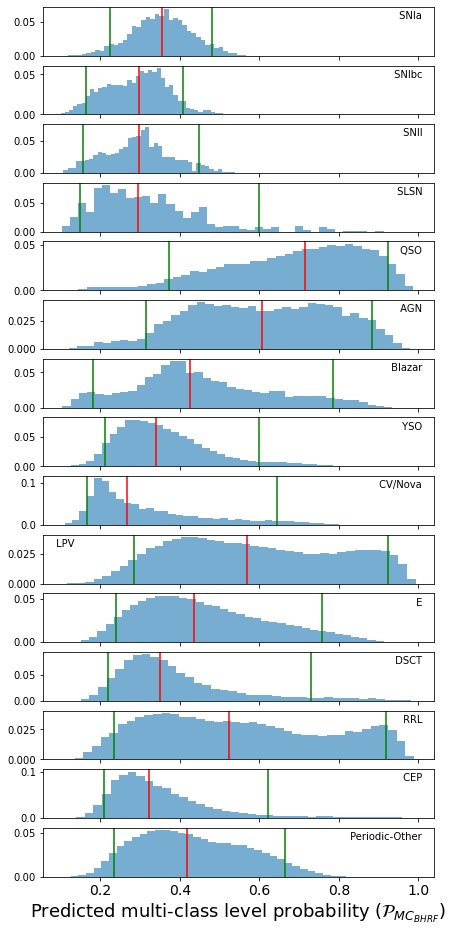

In [34]:
#plotting multi-class level probabilities

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="LPV"): 
       ax[idx].text(0.08, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
   else: 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')

plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$)',fontsize=18)
#plt.savefig('final_BHRF_model_20200916/plots/prob_dist_unlabeled_set.pdf',bbox_inches='tight')

In [35]:
#for SN stats in paper
np.percentile(test_data_withclass['SLSN_prob'][test_data_withclass['predicted_class']=="SNII"].values, 50)


0.18384799999999998

[ 0.41639056 -0.15434901  0.01732797 ...  0.45726395  0.389184
 -0.13401966]


[Text(1, 0, '0.2'),
 Text(1, 0, '0.3'),
 Text(1, 0, '0.4'),
 Text(1, 0, '0.5'),
 Text(1, 0, '0.6'),
 Text(1, 0, '0.7')]

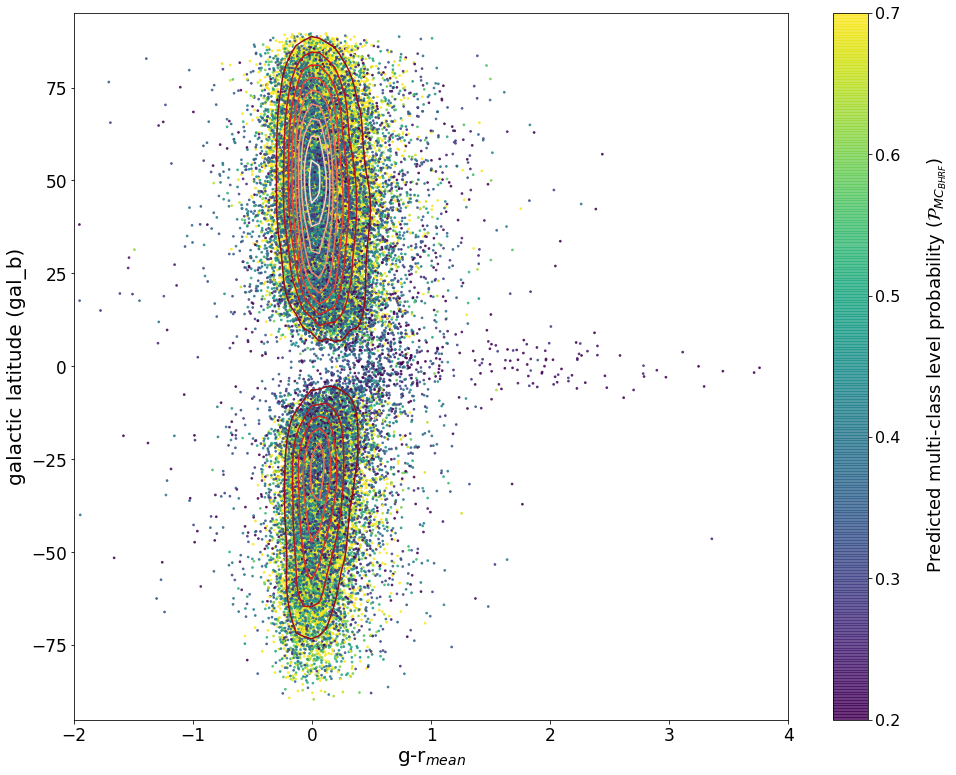

In [36]:
import matplotlib.cm as cm
import seaborn as sns

feature_x = 'g-r_mean'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
color_list = []

for idx, cl in enumerate(labels_list):
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   color_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
    
gal_b_array = np.array(gal_b_list)
color_array = np.array(color_list)

print(color_array)

ax = sns.kdeplot(color_array,gal_b_array, n_levels=10, cmap="Reds_r", shade=False)
    
cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$) ', rotation=90,fontsize=18)

#plt.legend(fontsize=15)
plt.xlabel(r'g-r$_{mean}$',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

#plt.savefig('final_BHRF_model_20200916/plots/color_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

[145.85286437  76.04075973  85.8230395  ... 104.36857292  58.52122329
 109.38197073]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 <a list of 9 Text major ticklabel objects>)

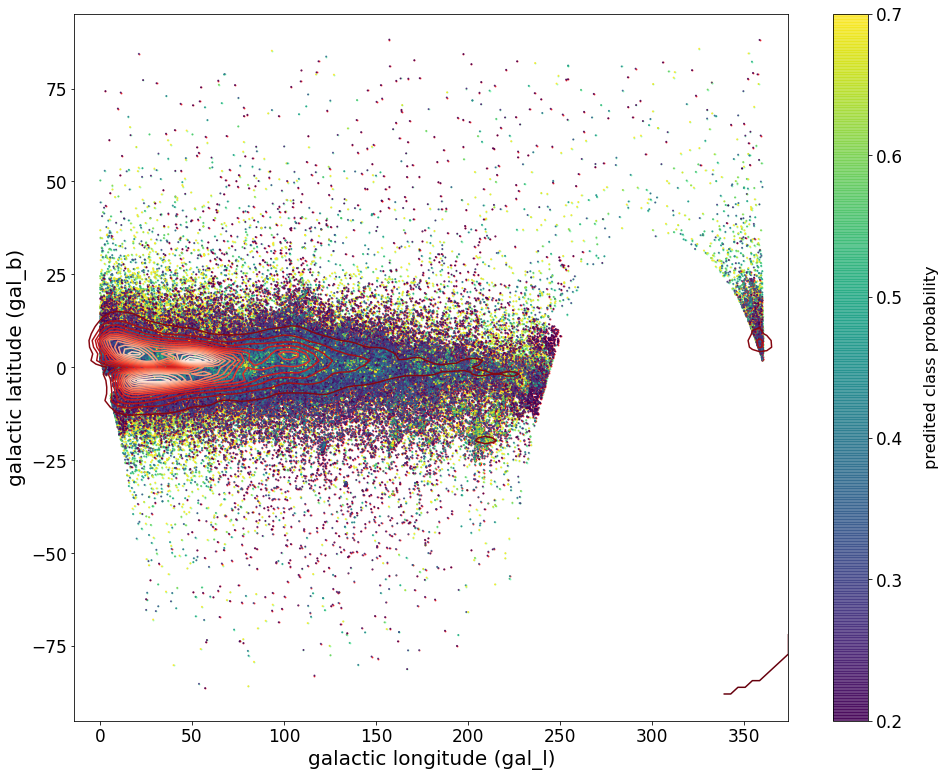

In [37]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['Ceph','LPV','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#plt.savefig('final_BHRF_model_20200916/plots/gal_l_gal_b_selection_galactic.png',bbox_inches='tight',dpi=200)

[204.46302346 179.37883376  72.06156315 ... 100.23486899  80.9934079
 338.30919314]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 <a list of 9 Text major ticklabel objects>)

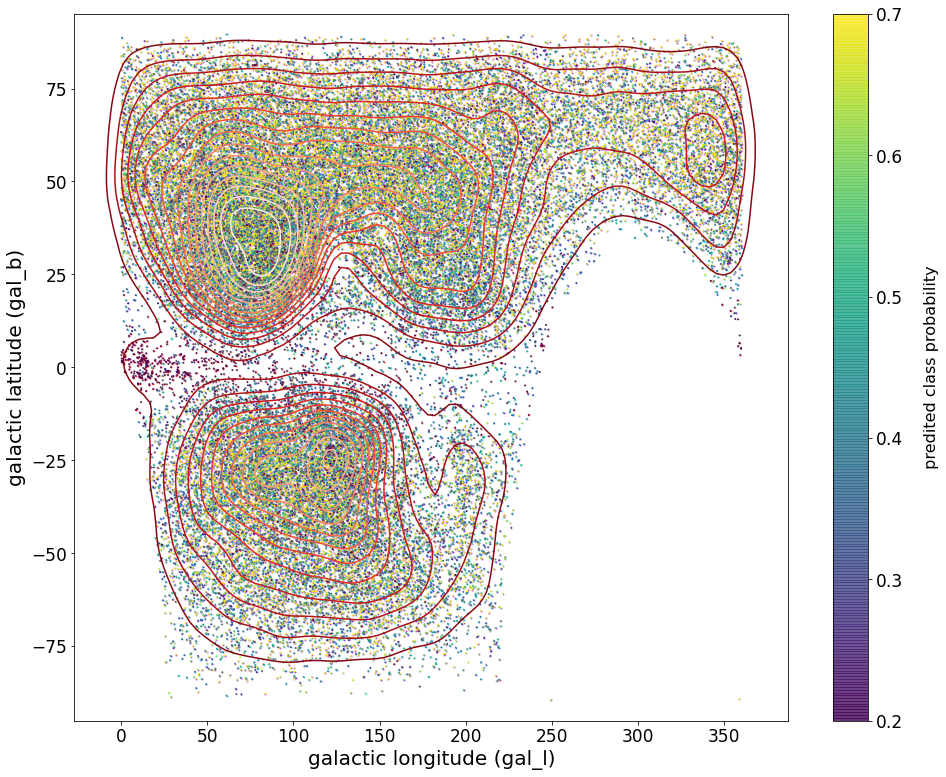

In [38]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#plt.savefig('final_BHRF_model_20200916/plots/gal_l_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

(array([10., 12., 14., 16., 18., 20., 22.]),
 <a list of 7 Text major ticklabel objects>)

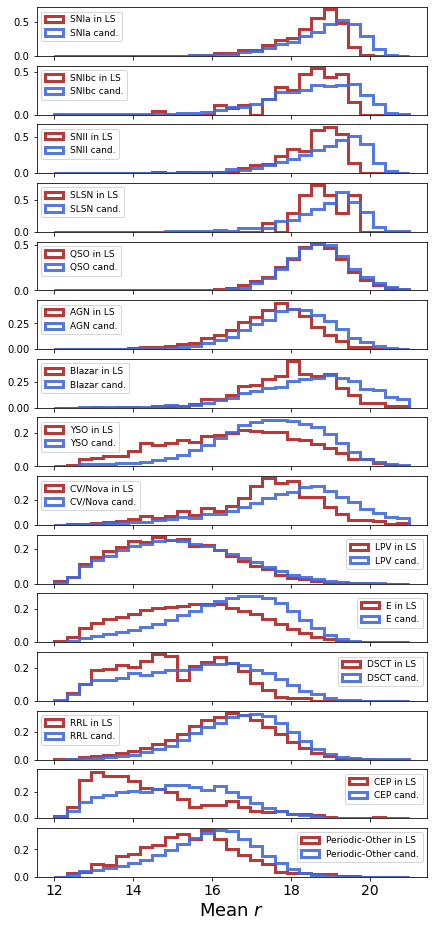

In [39]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature = 'Mean_2'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order),ncols=1, figsize=(7,16), sharex=True)


bins_hist = np.linspace(12,21,30)

for idx, cl in enumerate(label_order):
   
   if idx<=14:
       ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label=cl+' in LS', alpha=0.9)
       ax[idx].hist(test_data_withclass[feature][test_data_withclass['predicted_class']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label=cl+' cand.', alpha=0.9)
       
       if ((cl=="Periodic-Other") | (cl=="E") | (cl=="DSCT") | (cl=="CEP") | (cl=="LPV") ): ax[idx].legend(loc='upper right',fontsize=9)
        
       else: ax[idx].legend(loc='upper left',fontsize=9)
   
   else:
        break


ax[len(label_order)-1].set_xlabel(r'Mean $r$',fontsize=18)
plt.xticks(fontsize = 14)

#plt.savefig('final_BHRF_model_20200916/plots/Rband_magnitude_dist.pdf',bbox_inches='tight')